<a href="https://colab.research.google.com/github/leonardoLavagna/Drug-repurposing/blob/main/BI_LeoL_v10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Set up

In [ ]:
# MOUNT DRIVE
# Remark . Assign colab = True when using Google Colab
# Remark . While using Google colab remeber to collect all the needed files in
#          the folder BI-Data in your Google Drive.

import os
colab=True
if colab:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    os.chdir('/content/drive/MyDrive/BI-Data/')

In [2]:
# REFERENCE CODE FOR DIAMOnD

#!git clone https://github.com/dinaghiassian/DIAMOnD 

In [3]:
# IF CONFLICTS ARISE, UPGRADE THE FOLLOWING LIBRARIES

#%pip install networkx --upgrade
#%pip install scipy --upgrade

In [ ]:
# INSTALL NON-STANDARD LIBRARIES
# See: https://github.com/GuyAllard/markov_clustering

%pip install markov_clustering 

In [ ]:
# INSTALL NON-STANDARD LIBRARIES 
#See: https://ndex2.readthedocs.io/en/latest/createnicecx.html

%pip install ndex2

In [6]:
# DIRECTORY TREE
# Remark . Change according to your file system.
# Remark. This path should be the same used in the auxiliary_funtions module.
# Remark . When using Google Colab remember that the path has been changed to 
# /content/drive/MyDrive/BI-Data/ 

path = './'

In [7]:
# IMPORT NEEDED LIBRARIES AND SELF DEFINED FUNCTIONS

import re
import csv
import random
import json
import ast
import sys
import statistics
import ndex2
import requests
import base64
import auxiliary_functions as AF
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import markov_clustering as mc
from tqdm import tqdm
from scipy.stats import hypergeom

In [ ]:
# GLOBAL VARIABLES NAMES
"""
HSN: homo sapiens interactome
DGA: disease gene association
LCC or G: large connected component in HSN
seeds: seed gene' symbols
"""


In [ ]:
# NEEDED FILES
"""
1. BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt
2. curated_gene_disease_associations.tsv
3. DIAMOnD.py
4. DIaBLE.py
5. auxiliary_functions.py
6. diff_res.txt
"""

In [ ]:
# IMPORTANT FILES CREATED AND OFTEN USED
"""
1. Hypertensive disease_seed_gene.txt
2. Hypertensive disease_splits.json
3. PPI_Hypertensive.txt
4. cross{i} for i=0,1,2,3,4
5. probeset{i} for i=0,1,2,3,4
6. res{i} for i=0,1,2,3,4
7. splits.json
"""

# TASK 1 . PPI and GDA data gathering and interactome reconstruction

## Data gathering and interactome reconstruction

In [8]:
# DATA GATHERING AND PROCESSING

HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")
DGA_all = pd.read_csv(path+'curated_gene_disease_associations.tsv',sep='\t')
DGA =  DGA_all[DGA_all['diseaseName'] == 'Hypertensive disease']
DGA = AF.DGA_processing(path+'curated_gene_disease_associations.tsv', 'Hypertensive disease')

Processing interactome...


<ipython-input-8-ea389ed6b4af>:3: DtypeWarning: Columns (1,2,18) have mixed types.Specify dtype option on import or set low_memory=False.
  HSN = AF.interactome_processing(path+"BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt")


# Process completed.


In [9]:
# CREATE INTERACTOME AND SPLITS
# Remark . If the file 'Hypertensive disease_splits' has not been created
#          uncomment the following line

#DG_in_PPI,splits = AF.make_seeds_splits(DGA,HSN,'Hypertensive disease',path)
DG_in_PPI, splits = AF.import_seeds_split('Hypertensive disease')

Importing seed genes...
# Process completed.


## Compute the disease LCC and its basic network measures

In [10]:
# LCC COMPUTATION

LCC = AF.extract_LCC_form_PPI(HSN)
n_nodes = LCC.number_of_nodes()

Extracting LCC...
Nodes  19618 , Connections  665061
# Process completed.


Creating Disease LCC graph...
Nodes in disease LCC  232
# Process completed.


/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


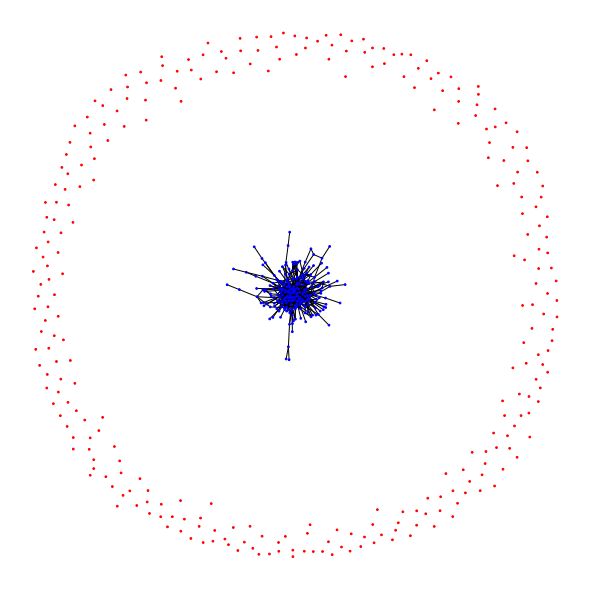

In [11]:
# LCC PLOT

DN = AF.make_disease_graph(HSN, DGA, DG_in_PPI)
AF.plot_LCC(DN, DG_in_PPI)

In [ ]:
# NETWORK MEASURES
# Remark . Execute only once. Moreover this cell takes a while to run...

G = LCC

nx.set_node_attributes(G, G.degree(), 'Node degree')  
nx.set_node_attributes(G, nx.betweenness_centrality(G), "Betweenness centrality")
nx.set_node_attributes(G, nx.eigenvector_centrality(G), "Eigenvector centrality")
nx.set_node_attributes(G, nx.closeness_centrality(G), "Closeness centrality")

local_measures = pd.DataFrame(index=G.nodes())
local_measures['Node degree'] = [d for n, d in G.degree()] 
local_measures['Betweenness centrality'] = pd.Series(nx.get_node_attributes(G, 'Betweenness centrality'))
local_measures['Eigenvector centrality'] = pd.Series(nx.get_node_attributes(G, 'Eigenvector centrality'))
local_measures['Closeness centrality'] = pd.Series(nx.get_node_attributes(G, 'Closeness centrality'))
local_measures['Betweenness/Degree Ratio'] = local_measures['Betweenness centrality']/local_measures['Node degree']
local_measures.index.name='Gene'

In [ ]:
# SAVE TABLE WITH NETWORK MEASURES IN FILE local_measures.csv
# Remark . Execute only once to create the file

local_measures.to_csv(path+'local_measures.csv', index = True, header = True)

In [ ]:
# CHECK

local_measures = pd.read_csv(path+'local_measures.csv', sep=',')
local_measures.head()

# Task 2 . Putative disease genes identification algorithms

## Set up

In [12]:
# STORE  THE INTERACTOME IN FILE PPI_Hypertensive.txt
# Remark . Execute only once to create the file

pairs_genes = list(LCC.edges)
textfile = open(path+"PPI_Hypertensive.txt", "w")
for gA, gB in tqdm(pairs_genes):
  textfile.write(str(gA) + ',' + str(gB) + '\n') 
textfile.close()

100%|██████████| 665061/665061 [00:00<00:00, 842064.40it/s]


In [13]:
# LOAD DATA

# Dict with pair k,v where k is the index and v is the list of genes in the probe set
with open(path+'Hypertensive disease_splits.json') as f:
  dict_ = json.load(f)

# import seed genes
with open(path+'Hypertensive disease_seed_gene.txt') as f:
  data = f.read()
  seeds = ast.literal_eval(data)
  seeds = np.asarray(seeds)     

In [14]:
# CHECK

#dict_.items()

In [15]:
# CHECK

#print(type(dict_))
#print(len(dict_["0"]))

In [16]:
# CROSS VALIDATION SPLITS INTO FILES 
# Remark . Execute only once to create the files

for k,v in dict_.items():
    print(k,v)

    with open(path+'probeset{}.txt'.format(k),'w') as f:
        for item in v:
            f.write("%s," % item)   

    l=list(set(seeds).difference(set(v))) 
    # check
    # 58 is the probe set v
    # therefore 290-58 has to be the training set l
    print(len(l)==290-58)
 
    with open(path+'cross{}.txt'.format(k),'w') as f:
        for item in l:
            f.write("%s\n" % item)
    

0 ['ACT', 'CALR', 'PTEN', 'ATP1A2', 'WNK1', 'POMC', 'SOD3', 'NPPB', 'PRKG1', 'PRKCD', 'MC2R', 'ND6', 'NPHP1', 'B2M', 'MAFB', 'CYP17A1', 'IDUA', 'ATOX1', 'OXSR1', 'TGFB1', 'ITM2B', 'HSD11B2', 'CACNA1D', 'CACNA1C', 'SCNN1A', 'IKBKAP', 'TRNV', 'BBS7', 'CELA2A', 'IER3', 'TRIM32', 'GLA', 'ENPP1', 'MKS1', 'BMPR2', 'NPPA', 'LOX', 'FOXF1', 'ICAM1', 'MYLK', 'AGT', 'DUSP5', 'INVS', 'FOS', 'GSTT2', 'TNFRSF11B', 'ACVRL1', 'CPOX', 'FGFR2', 'EDNRA', 'IFT172', 'HP', 'NPTN', 'BBS9', 'INS', 'NPR1', 'ERAP1', 'SLC12A2']
True
1 ['NR3C1', 'STK39', 'HMBS', 'GSK3B', 'CAV1', 'CEP164', 'CYBB', 'SLC37A4', 'INPPL1', 'HSD11B1', 'SMAD3', 'TRH', 'GJA4', 'HMOX1', 'GUCY1A3', 'AGTR1', 'SMAD4', 'CALCA', 'F12', 'SH2B3', 'CLCNKA', 'PLIN1', 'KCNJ5', 'RET', 'TGFBR1', 'VHL', 'VAV3', 'ADRB1', 'CACNA2D1', 'ALMS1', 'CD36', 'UCN', 'CYP11B1', 'ADCY5', 'FMO3', 'CETP', 'GNAS', 'GNB3', 'PLG', 'APOE', 'BBS2', 'MMP9', 'LYZ', 'CMA1', 'PPP1R3A', 'UCP2', 'SERPINA6', 'SLC9A3R2', 'COL1A1', 'ABCB6', 'ELN', 'AR', 'COX3', 'FGA', 'TGM2', 'CUL

## Evaluation of performances for DIAMOnD

In [ ]:
# DIAMOnD ALGORITHM EVALUATION

tot = 200

!python3  DIAMOnD.py  PPI_Hypertensive.txt  cross0.txt  200 "res0.txt"
m = AF.evaluation(tot, 58, "DIAMOnD",0)
print(m)

!python3  DIAMOnD.py  PPI_Hypertensive.txt  cross1.txt  200 "res1.txt"
m = AF.evaluation(tot, 58, "DIAMOnD",1)
print(m)

!python3  DIAMOnD.py  PPI_Hypertensive.txt  cross2.txt  200 "res2.txt"
m = AF.evaluation(tot, 58, "DIAMOnD",2)  
print(m)


!python3  DIAMOnD.py  PPI_Hypertensive.txt  cross3.txt  200 "res3.txt"
m = AF.evaluation(tot, 58, "DIAMOnD",3)  
print(m)


!python3  DIAMOnD.py  PPI_Hypertensive.txt  cross4.txt  200 "res4.txt"
m = AF.evaluation(tot, 58, "DIAMOnD",4)  
print(m)


 results have been saved to 'res0.txt' 

{'PTEN'}
{'recall': [0.017], 'precision': [0.005], 'F1 Score': [0.008]}

 results have been saved to 'res1.txt' 

{'GSK3B', 'VCAM1', 'CAV1', 'AR'}
{'recall': [0.069], 'precision': [0.02], 'F1 Score': [0.031]}

 results have been saved to 'res2.txt' 

{'HIF1A'}
{'recall': [0.017], 'precision': [0.005], 'F1 Score': [0.008]}

 results have been saved to 'res3.txt' 

{'AHR'}
{'recall': [0.017], 'precision': [0.005], 'F1 Score': [0.008]}

 results have been saved to 'res4.txt' 

{'RELA', 'EGFR', 'TP53', 'BBS4'}
{'recall': [0.069], 'precision': [0.02], 'F1 Score': [0.031]}


#### Check

In [ ]:
#curated_gene_desease_association_DF = pd.read_csv("curated_gene_disease_associations.tsv", sep = '\t', compression = 'infer')
#disease_DF = curated_gene_desease_association_DF.loc[curated_gene_desease_association_DF['diseaseId'] == 'C0020538']

In [ ]:
#print("List of gene symbols:\n", *list(disease_DF['geneSymbol']))
#seed_genes_symbols = list(disease_DF['geneSymbol'])

In [ ]:
#len(set(list(LCC.nodes())).intersection(set(seed_genes_symbols)))

## Evaluation of performances for DIaBLE

In [ ]:
# DIaBLE ALGORITHM EVALUATION

#...

## Evaluation of performances for Diffusion

### Diffusion algorithm

In [17]:
# CREATE CX OBJECT FROM NETWORK

#CX = nx.cytoscape_data(LCC) 
CX = ndex2.create_nice_cx_from_networkx(LCC).to_cx()

Generating CX


In [18]:
#nice_cx_net = ndex2.create_nice_cx_from_server(server='http://public.ndexbio.org',
#                                               uuid='c0e70804-d848-11e6-86b1-0ac135e8bacf')

nice_cx_net = ndex2.create_nice_cx_from_raw_cx(CX)

In [19]:
# CHECK

print(nice_cx_net)

nodes: 19618 
 edges: 665061


In [20]:
# CHECK
# Remark . Remove break to have the complete (very long) list

for nodeid, nodeobj in nice_cx_net.get_nodes():
    nice_cx_net.remove_node_attribute(node=nodeid, attribute_name='diffusion_input')
    nice_cx_net.set_node_attribute(type='double', node=nodeid, attribute_name='diffusion_input', values='1.0')
    print(nice_cx_net.get_node_attribute(nodeid,'diffusion_input'))
    break

{'po': 0, 'n': 'diffusion_input', 'v': '1.0', 'd': 'double'}


In [21]:
# CALL THE DIFFUSION SERVICE
# Remark . This cell takes some time to run...

url = 'http://v3.heat-diffusion.cytoscape.io'
payload = nice_cx_net.to_cx()
for p in payload:
    k = list(p.keys())[0]
    if 'Attributes' in k:
        for i in range(len(p[k])):
            p[k][i]['v'] = str(p[k][i]['v'])
response = requests.post(url, json=payload)

Generating CX


In [22]:
# GET DIFFUSION RESULTS
# Remark . The data dictionary in the json response response.json()['data'] is a dictionary 
#          that contains CX formatted data with results of diffussion.

for aspect in response.json()['data']:
    if 'nodeAttributes' not in aspect:
        continue
    for n_attr in aspect['nodeAttributes']:
        if n_attr['n'] == 'diffusion_output_rank' or n_attr['n'] == 'diffusion_output_heat':
            if n_attr['d'] == 'float':
                n_type = 'double'
            else:
                n_type = n_attr['d']
            nice_cx_net.add_node_attribute(property_of=int(n_attr['po']),
                                 name=n_attr['n'],
                                 values=n_attr['v'],
                                 type=n_type)

In [23]:
# OUTPUT BEST RESULTS FROM DIFFUSION

nos = []
for node_id, node in nice_cx_net.get_nodes():
    rank = nice_cx_net.get_node_attribute_value(node_id, 'diffusion_output_rank')
    if int(rank) < 10:
        node['diffusion_output_rank'] = rank
        heat = nice_cx_net.get_node_attribute_value(node_id, 'diffusion_output_heat')
        node['diffusion_output_heat'] = float(heat)
        nos.append(node)

# sort the result
nos = sorted(nos, key=lambda k: k['diffusion_output_rank'])       
nos

[{'@id': 17324,
  'n': 'KTI12',
  'diffusion_output_rank': '0',
  'diffusion_output_heat': 0.012282198238729582},
 {'@id': 0,
  'n': 'MAP2K4',
  'diffusion_output_rank': '1',
  'diffusion_output_heat': 0.00761126646420888},
 {'@id': 7744,
  'n': 'TNFAIP8L1',
  'diffusion_output_rank': '2',
  'diffusion_output_heat': 0.005555268233717349},
 {'@id': 16532,
  'n': 'CYLC2',
  'diffusion_output_rank': '3',
  'diffusion_output_heat': 0.005427491891379121},
 {'@id': 149,
  'n': 'MAP3K8',
  'diffusion_output_rank': '4',
  'diffusion_output_heat': 0.004390518912032185},
 {'@id': 2961,
  'n': 'FBP2',
  'diffusion_output_rank': '5',
  'diffusion_output_heat': 0.003574010325371949},
 {'@id': 2372,
  'n': 'MAP3K10',
  'diffusion_output_rank': '6',
  'diffusion_output_heat': 0.003214825050752872},
 {'@id': 7146,
  'n': 'ALDOB',
  'diffusion_output_rank': '7',
  'diffusion_output_heat': 0.0021691145593946064},
 {'@id': 3698,
  'n': 'MAP3K11',
  'diffusion_output_rank': '8',
  'diffusion_output_heat':

In [33]:
# THE RESULTS HAVE BEEN SAVED IN THE FOLLOWING txt FILE

data=pd.read_csv('diff_res.txt'.format(i),sep='\t')

In [43]:
# SORTING
data=data.sort_values(by='diffusion_output_heat',ascending=False)
print(data)

   #rank       name  diffusion_output_heat
0      0      KTI12               0.012282
1      1     MAP2K4               0.007611
2      2  TNFAIP8L1               0.005555
3      3      CYLC2               0.005427
4      4     MAP3K8               0.004391
5      5       FBP2               0.003574
6      6    MAP3K10               0.003215
7      7      ALDOB               0.002169
8      9    MAP3K11               0.001414
9     10       BLNK               0.001338


### Evaluation

In [47]:
# AUXILIARY FUNCTIONS TO PUT IN FILE auxiliary_functions.py

def D_evaluation(top_n, disease_dict, DGA=DGA_all, data=data):
    
    recall_=[]
    f1_score_=[]
    precision_=[]

    recall_all=[]
    f1_score_all=[]
    precision_all=[]
    

    all_DGA=set(DGA[DGA['diseaseName'] == 'Hypertensive disease'].geneId)

    for i in range(5):
        ids=DGA[DGA.geneSymbol.isin(dict_[str(i)])].geneId.tolist()
        probe_length=len(ids)
        new=data[0:top_n]

        num=len(set(new).intersection(ids))
        pre=num/top_n
        precision_.append(pre)
        rec=num/len(ids)
        recall_.append(rec)
        f1=2*(pre*rec)/(pre+rec+0.0001)
        f1_score_.append(f1)

        TP=set(new).intersection(ids)
        FP=[x for x in new if x not in ids]
        FP=FP[:len(ids)]

        num=len(set(FP).intersection(all_DGA))
        pre=num/len(FP)
        rec=num/len(all_DGA)
        f1=2*(pre*rec)/(pre+rec+0.0001)
        precision_all.append(pre)
        recall_all.append(rec)
        f1_score_all.append(f1)
    

    disease_dict['precision']['std_valid'][str(top_n)]={}
    disease_dict['precision']['std_valid'][str(top_n)]['mean']=np.average(precision_)
    disease_dict['precision']['std_valid'][str(top_n)]['sd']=np.std(precision_)

    disease_dict['recall']['std_valid'][str(top_n)]={}
    disease_dict['recall']['std_valid'][str(top_n)]['mean']=np.average(recall_)
    disease_dict['recall']['std_valid'][str(top_n)]['sd']=np.std(recall_)

    disease_dict['f1_score']['std_valid'][str(top_n)]={}
    disease_dict['f1_score']['std_valid'][str(top_n)]['mean']=np.average(f1_score_)
    disease_dict['f1_score']['std_valid'][str(top_n)]['sd']=np.std(f1_score_)

    disease_dict['precision']['ext_valid'][str(top_n)]={}
    disease_dict['precision']['ext_valid'][str(top_n)]['mean']=np.average(precision_all)
    disease_dict['precision']['ext_valid'][str(top_n)]['sd']=np.std(precision_all)

    disease_dict['recall']['ext_valid'][str(top_n)]={}
    disease_dict['recall']['ext_valid'][str(top_n)]['mean']=np.average(recall_all)
    disease_dict['recall']['ext_valid'][str(top_n)]['sd']=np.std(recall_all)

    disease_dict['f1_score']['ext_valid'][str(top_n)]={}
    disease_dict['f1_score']['ext_valid'][str(top_n)]['mean']=np.average(f1_score_all)
    disease_dict['f1_score']['ext_valid'][str(top_n)]['sd']=np.std(f1_score_all)

In [48]:
# INITIALIZATION BEFORE DIFFUSION EVALUATION

Pre_con_diffusion_results={}
Pre_con_diffusion_results['precision']={}
Pre_con_diffusion_results['recall']={}
Pre_con_diffusion_results['f1_score']={}

for i in Pre_con_diffusion_results.keys():
    Pre_con_diffusion_results[i]['std_valid']={}
    Pre_con_diffusion_results[i]['ext_valid']={}


In [49]:
# CHECK
for size in [100,250,500,1000]:
    D_evaluation(size,Pre_con_diffusion_results)

In [ ]:
# DIFFUSION ALGORITHM EVALUATION 

for size in [100,250,500,1000]:
    AF.D_evaluation(size,Pre_con_diffusion_results)

In [50]:
# DISPLAY THE RESULTS

AF.display_dict(Pre_con_diffusion_results) ##<<---------- ?? -----------------


{
     precision : {
         std_valid : {
             100 : {
                 mean : 0.0
                 sd : 0.0
             }
             250 : {
                 mean : 0.0
                 sd : 0.0
             }
             500 : {
                 mean : 0.0
                 sd : 0.0
             }
             1000 : {
                 mean : 0.0
                 sd : 0.0
             }
         }
         ext_valid : {
             100 : {
                 mean : 0.0
                 sd : 0.0
             }
             250 : {
                 mean : 0.0
                 sd : 0.0
             }
             500 : {
                 mean : 0.0
                 sd : 0.0
             }
             1000 : {
                 mean : 0.0
                 sd : 0.0
             }
         }
     }
     recall : {
         std_valid : {
             100 : {
                 mean : 0.0
                 sd : 0.0
             }
             250 : {
                 mean : 0.0
    

# Task 3 Putative disease genes identification

## Set up

In [ ]:
# IN ORDER TO USE nx.to_scipy_sparse_matrix THE PROPER VERSION OF networkx IS NEEDED
# IF NEEDED UNINSTALL IT AND REINSTALL THE CORRECT VERSION
# Remark . Sometimes it is needed to restart the kernel to apply these changes

#%pip uninstall networkx
#%pip install networkx==2.3

In [ ]:
# IMPORT 

#import networkx as nx

In [12]:
# GRAPH

G = LCC

## MCL

In [13]:
# CLUSTERS

result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))           
clusters = mc.get_clusters(result) 

In [15]:
# PLOT
# Remark . This cell takes a while to run...

#mc.draw_graph(nx.to_scipy_sparse_matrix(G), clusters, node_size=10, with_labels=False, edge_color="silver")

In [ ]:
# CLUSTERING WITH DIFFERENT INFLATION VALUES AND MODULARITY COMPUTATION
# Remark . This cell takes a while to run...
# Remark . A standard RAM cannot usually carry out the computation

matrix = nx.to_scipy_sparse_matrix(G)

for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

In [ ]:
# KEEP CLUSTERS WITH AT LEAST 10 GENES

big_clusters = []
for module in clusters:
    if len(module) >= 10:
        big_clusters.append(module)
print(len(clusters), len(big_clusters))

In [ ]:
# DICTIONARY WITH MAPPING Ids-->Names

val = range(G.number_of_nodes())
names = list(G.nodes())
dic = dict(zip(val, names))

In [ ]:
# RUN hypergeometric test TO FIND MODULES WITH OVER-REPRESENTED GENES

putative_desease_modules = []
M = G.number_of_nodes()  
n = len(seeds) 
p_val_list = []
for module in big_clusters:
    # number of draws (number of genes in the given cluster)
    N = len(module) 
    x = len(set(seeds).intersection(set(dic[g] for g in module)))
    p_val = hypergeom.sf(x-1, M, n, N)
    if p_val < 0.05:
        putative_desease_modules.append(module)
        p_val_list.append(p_val)